<a href="https://colab.research.google.com/github/Tiago1Ribeiro/OpenAI_gym_environment/blob/master/OpenAI_gym_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Testing Gym (OpenAI): https://gym.openai.com/docs/

####Install dependencies

In [4]:
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install xvfbwrapper
!pip3 install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1756589374'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1756589374'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

####Import libraries

In [0]:
import numpy as np
import time
import pyglet
import gym
import PIL.Image
import io    

####Virtual Display to [Colab](https://colab.research.google.com)

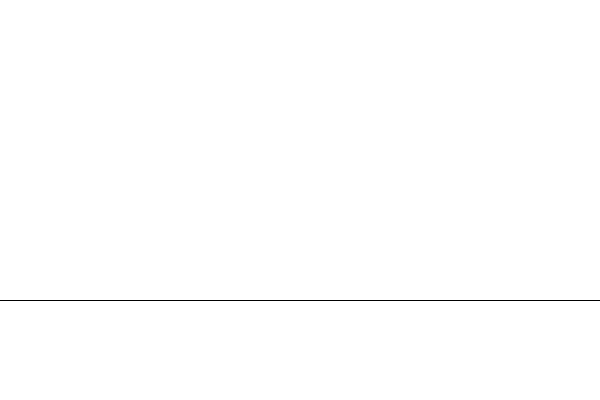

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
# Virtual display (Colab.google)
from pyvirtualdisplay import Display
from IPython import display
from xvfbwrapper import Xvfb

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
vdisplay = Xvfb(width=1280, height=740)
vdisplay.start()

env = gym.make('CartPole-v0')
env.reset()

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = io.BytesIO()
    ima = PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()
imagehandle = display.display(display.Image(data=showarray(env.render(mode='rgb_array')), width=450), display_id='gymscr')


for _ in range(1000):
  time.sleep(0.01)
  observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
  display.update_display(display.Image(data=showarray(env.render(mode='rgb_array')), width=450), display_id='gymscr')
  
vdisplay.stop()